In [163]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['axes.linewidth'] = 2.0

In [164]:
try:
    with open('./smf_cosmos.dat', 'r') as file:
        data_array = np.genfromtxt(file,delimiter='')
except FileNotFoundError:
    print("Error: The file 'smf_cosmos.dat' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

log_Mgal = np.zeros(len(data_array))

n_Mgal = np.zeros(len(data_array))

error_Mgal = np.zeros(len(data_array))

for i in range(len(data_array)):
    log_Mgal[i]=data_array[i][0]
    n_Mgal[i]=data_array[i][1]
    error_Mgal[i]=data_array[i][2]

In [165]:
def mass_fn(logMgal,xvec):
    logphistar, alpha, logMstar = xvec
    return np.pow(10,logphistar)*np.pow(np.pow(10,logMgal)/np.pow(10,logMstar),alpha+1)*np.exp(-np.pow(10,logMgal)/np.pow(10,logMstar))*np.log(10) # note the logs here are base 10

def chi_sqr_wrapper(nvec,logMgalvec,sigmavec):
    n,logMgal,sigma = nvec,logMgalvec,sigmavec
    def chi_sqr(xvec):
        chisqr = 0 # if I want to pass this arrays of chisqr eventually I'll need to change this probably
        for i in range(len(n)):
            chisqr+= np.pow(n[i]-mass_fn(logMgal[i],xvec),2)/np.pow(sigma[i],2)
        return chisqr
    return chi_sqr
    
    
def find_minimum(func,xvecguess,gamma,etol,h_init,**kwargs):
    # if we are fitting the mass function, initialize the arrays needed to calculate chi squared.
    if 'nvec' in kwargs and 'logMgalvec' in kwargs and 'sigmavec' in kwargs:
        chi_sqr = chi_sqr_wrapper(kwargs['nvec'], kwargs['logMgalvec'], kwargs['sigmavec'])
        func = chi_sqr # set the function to chi_sqr
    
    # initialize the first step
    xold = xvecguess
    xnew = np.zeros(len(xvecguess))
    for i in range(len(xold)):
        xnew[i] = xold[i] - gamma*h_init

    # while the change each step is greater than your tolerance, descend down the gradient.
    xold_=xnew
    xoldold_=xold
    xnew_=np.zeros(len(xvecguess))
    function_array = np.array([]) # an array of the values of the function calculated each iteration
    while math.dist(xnew_, xoldold_) > etol:
        for i in range(len(xold_)):
            xmid = np.copy(xoldold_) # setup the vector where we have moved in only one direction
            xmid[i] = xold_[i]
            xnew_[i] = xold_[i] - gamma*((func(xmid) - func(xoldold_))/(xold_[i]-xoldold_[i])) # change the values of x_new; this is x_(i+1)
        xoldold_ = np.copy(xold_) # this is the x_(i-1) which we need for the derivative
        xold_ = np.copy(xnew_) # update the value of the old step, this is x_i
        function_array = np.append(function_array,func(xnew_))
    xfinal = np.copy(xnew_) # the final values of xnew are the correct ones
    return xfinal, function_array

In [166]:
testfunc = lambda x: (x[0]-2)**2 + (x[1]-2)**2 
testvecfinal, function_array = find_minimum(testfunc,xvecguess=[3,3],gamma=1e-1,etol=0.0001,h_init=0.01)
print(testvecfinal)
print(testfunc(testvecfinal))

[1.99980415 1.99980415]
7.671144519111237e-08


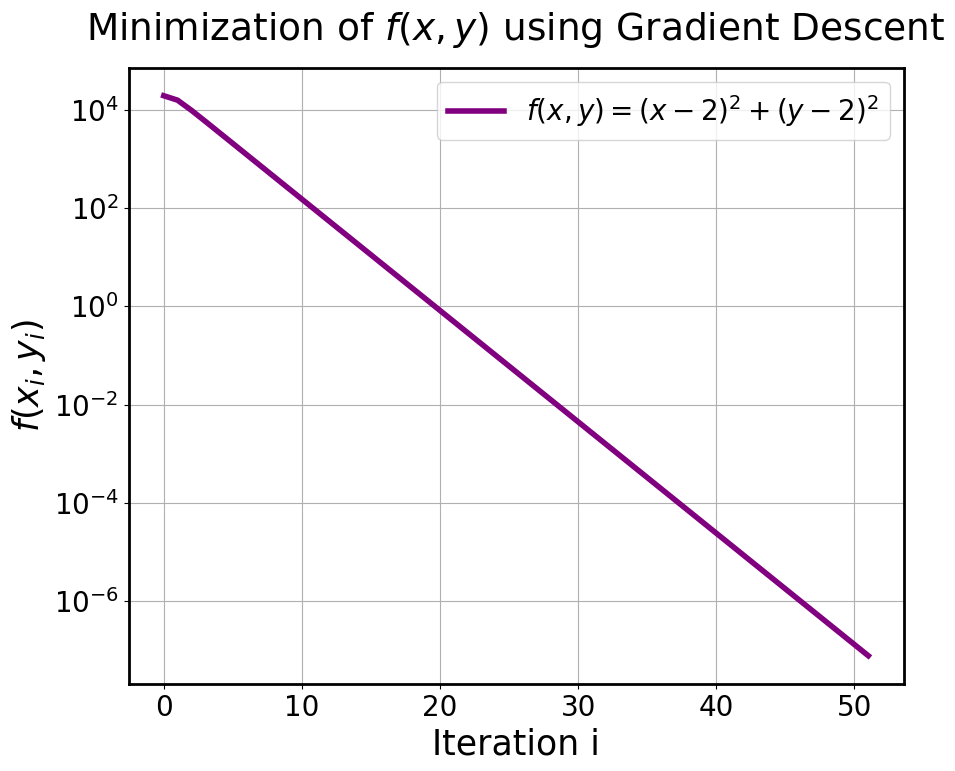

In [167]:
plt.figure(figsize=(10,8),dpi=100)
plt.semilogy(np.arange(len(function_array)),function_array,lw=4,color='purple',label=r'$f(x,y)=(x-2)^2 + (y-2)^2$')
plt.xlabel(r'Iteration i',fontsize=25)
plt.ylabel(r'$f(x_i,y_i)$',fontsize=25)
plt.title(r'Minimization of $f(x,y)$ using Gradient Descent',fontsize=27,pad='20')
plt.grid(True,which='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right',fontsize=20)
plt.tick_params(labelbottom=True)
plt.tick_params(labelleft=True)

plt.savefig('./hw2_p3_test_fn_minimization.png',bbox_inches="tight")

In [168]:
xvecfinal1, chisqrfinal1 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-3.2,-0.5,11.5]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal) # pretty sure these are the values from class...

# Try and see if we get roughly the same result for a few different initial conditions
xvecfinal2, chisqrfinal2 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-2,-0.9,10]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal)
xvecfinal3, chisqrfinal3 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-2.3,-0.6,9]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal)
xvecfinal4, chisqrfinal4 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-4,-0.7,10.5]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal)
xvecfinal5, chisqrfinal5 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-2.5,-0.4,11]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal)
xvecfinal6, chisqrfinal6 = find_minimum(chi_sqr_wrapper,xvecguess=np.array([-2.3,-0.7,9]),gamma=1e-4,etol=0.001,h_init=0.1,nvec=n_Mgal,logMgalvec=log_Mgal,sigmavec=error_Mgal)

print(f'For x_init = [-3.2,-0.5,11.5], we obtain: x_final = {xvecfinal1}')
print(f'For x_init = [-2,-0.9,10], we obtain: x_final = {xvecfinal2}')
print(f'For x_init = [-2.3,-0.6,9], we obtain: x_final = {xvecfinal3}')
print(f'For x_init = [-4,-0.7,10.5], we obtain: x_final = {xvecfinal4}')
print(f'For x_init = [-2.5,-0.4,11], we obtain: x_final = {xvecfinal5}')
print(f'For x_init = [-2.3,-0.7,9], we obtain: x_final = {xvecfinal6}')

For x_init = [-3.2,-0.5,11.5], we obtain: x_final = [-2.60642128 -1.04577514 11.00032182]
For x_init = [-2,-0.9,10], we obtain: x_final = [-2.53230244 -0.97319458 10.95250033]
For x_init = [-2.3,-0.6,9], we obtain: x_final = [-2.53218446 -0.9730722  10.95242052]
For x_init = [-4,-0.7,10.5], we obtain: x_final = [-2.60686862 -1.04639332 11.00073674]
For x_init = [-2.5,-0.4,11], we obtain: x_final = [-2.53231953 -0.97321231 10.95251189]
For x_init = [-2.3,-0.7,9], we obtain: x_final = [-2.53196886 -0.97284847 10.95227464]


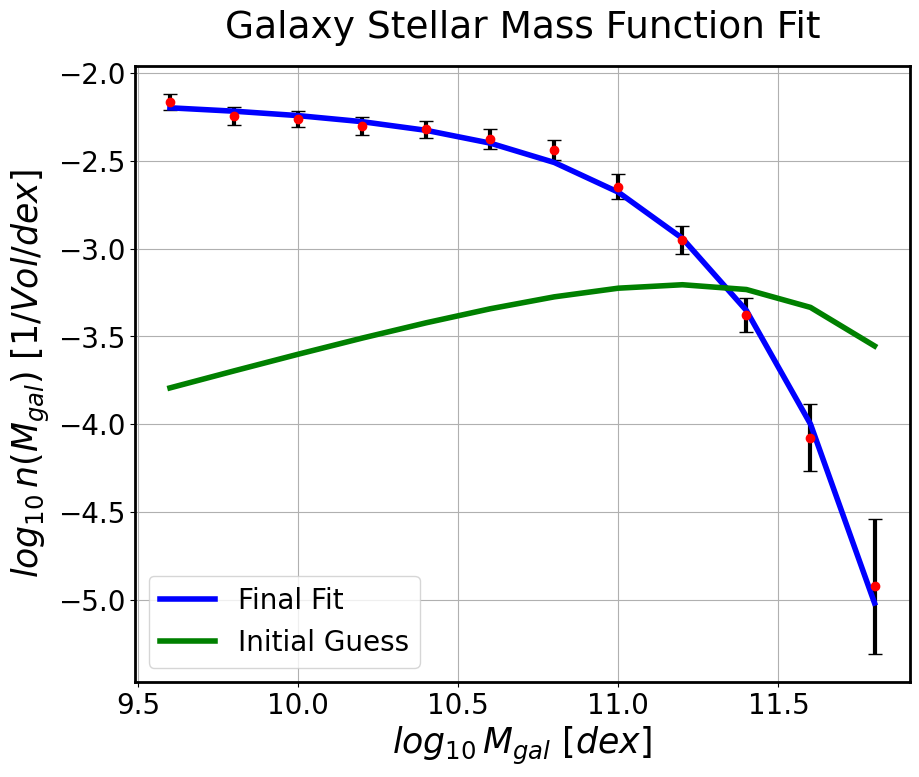

In [169]:
plt.figure(figsize=(10,8),dpi=100)
plt.errorbar(log_Mgal,np.log10(n_Mgal), yerr=(1 / (np.log(10) *n_Mgal)) * error_Mgal,color='red', fmt='o', capsize=5, ecolor='k', elinewidth=3) # the formula here is just the 
plt.plot(log_Mgal,np.log10(mass_fn(log_Mgal,xvec=xvecfinal1)),label=r'Final Fit',lw=4,color='blue')
plt.plot(log_Mgal,np.log10(mass_fn(log_Mgal,xvec=[-3.2,-0.5,11.5])),label=r'Initial Guess',lw=4, color='green')
plt.xlabel(r'$log_{10}\, M_{gal} \,\,[dex]$',fontsize=25)
plt.ylabel(r'$log_{10}\, n(M_{gal}) \,\,[1/Vol/dex]$',fontsize=25)
plt.title(r'Galaxy Stellar Mass Function Fit',fontsize=27,pad='20')
plt.legend(loc='lower left',fontsize=20)
plt.grid(True,which='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tick_params(labelbottom=True)
plt.tick_params(labelleft=True)

plt.savefig('./hw2_p3_final_function.png',bbox_inches="tight")

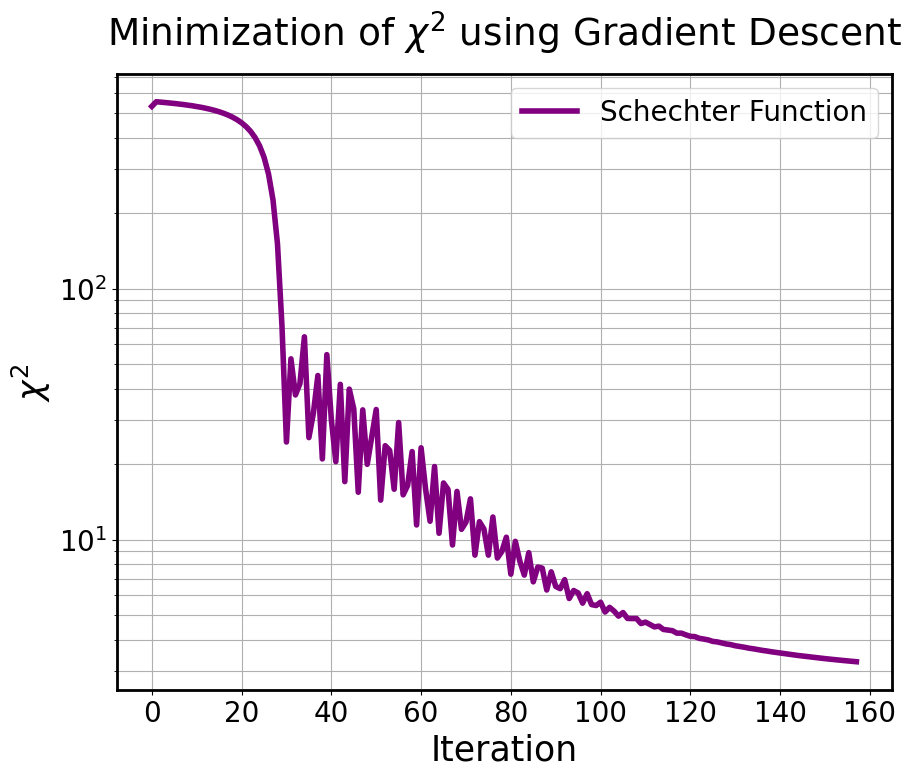

In [170]:
plt.figure(figsize=(10,8),dpi=100)
plt.semilogy(np.arange(len(chisqrfinal1)),chisqrfinal1,lw=4,color='Purple',label='Schechter Function')
plt.xlabel(r'Iteration',fontsize=25)
plt.ylabel(r'$\chi^2$',fontsize=25)
plt.grid(True,which='both')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(r'Minimization of $\chi^2$ using Gradient Descent',fontsize=27,pad='20')
plt.legend(loc='upper right',fontsize=20)
plt.tick_params(labelbottom=True)
plt.tick_params(labelleft=True)
plt.savefig('./hw2_p3_final_fn_chisqr.png',bbox_inches="tight")